In [1]:
import EPUtils
import gdas
from datetime import datetime, timedelta
import numpy as np
import numpy.ma as ma
import scipy.optimize as opt
import matplotlib.pyplot as plt
import random
import copy
import pickle

/home/user/anaconda3/envs/lalsuite-dev/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/user/anaconda3/envs/lalsuite-dev/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setupto

In [2]:
STATION_STANDARD_DEVIATIONS = {
    'berkeley02': 2.0,
    'berkeley01': 4.0,
    'daejeon01': 0.2,
    'hayward01': 0.1,
    'krakow01': 0.8,
    'lewisburg01': 0.1,
    'mainz01': 0.1,
    'losangeles01': 1.5,
    'moxa01': 1.0,
    'oberlin01': 0.2
}

STATION_SENSITIVE_AXES = { # in form: longitude, long direction?, lattitude, lat direction?, azimuth, altitude
    'beijing01': (116.1868,'E',40.2457,'N',251,0),
    'berkeley02': (122.2570,'W',37.8723,'N',0,90),
    'canberra01': (149.1185,'E',35.2745,'S',0,90),
    'daejeon01': (127.3987,'E',36.3909,'N',0,90),
    'hayward01': (122.0539,'W',37.6564,'N',0,90),
    'krakow01': (19.9048,'E',50.0289,'N',0,90),
    'lewisburg01': (76.8825,'W',40.9557,'N',0,90),
    'losangeles01': (118.4407,'W',34.0705,'N',270,0),
    'mainz01': (8.2354,'E',49.9915,'N',0,-90),
    'moxa01': (11.6147,'E',50.6450,'N',270,0),
    'oberlin01': (82.2204,'W', 41.2950,'N',276,0),
    'belgrade01': (20.3928,'E',44.8546,'N',300,0),
    'test01': (0,'E',0,'N',0,90),
    'test02': (45,'E',30,'N',0,90),
    'test03': (120,'W',45,'N',0,90),
    'test04': (83,'E',20,'N',0,90),
    'test05': (113,'W',45,'S',0,90),
    'test06': (20,'E',17,'S',0,90)
}

STATION_LIST =['test01','test02','test03','test04','test05','test06'] #'test','test','test','test','test','test','test','test']
# STATION_LIST = ['krakow01','hayward01','lewisburg01', 'mainz01', 'moxa01','daejeon01']
BANDWIDTH_LIMIT = 100 #Hz
FREQUENCY_SAMPLING_RATE = 512 #Hz
NUMBER_COINCIDENCE = 4

filepath = "/mnt/d/AxionAnalysis/"
start_date = "2020-02-03-19-00-43"
end_date = EPUtils.get_end_time(start_date, 2048)
window_length = 2048 # seconds
min_time_seg_length = 2 # seconds

## END OF USER DEFINED CONSTS ##




In [ ]:
signals = np.linspace(.01,0.25,20)
signals = np.append(signals, np.linspace(.3,.5,5))
print(signals)
mins = []
maxs = []
means = []

alldata = []
mlists = []

# for s in signals:
for s in np.array([0,.1,.5]):
# for s in np.array([0,.1,.3,.5,5,10,20]):

    burst_amplitude = 2
    ep_threshold = 130
    veclst = []
    x2 = []
    ms =[]
    for i in range(500):
        
        xtemp = random.uniform(-1, 1)
        ytemp = random.uniform(-1, 1)
        ztemp = random.uniform(-1, 1) 
        norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
        signal_vector = [burst_amplitude*xtemp/norm_factor, burst_amplitude*ytemp/norm_factor, burst_amplitude*ztemp/norm_factor]
        signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]
        
        ## FOR SPHERICAL COORDINATES ##
        # this should not be used as it does not provide an even distribution of x,y,z coordinate points
        
        # phi = random.random()*np.pi
        # theta = random.random()*np.pi*2
        # signal_vector = [burst_amplitude*np.sin(phi)*np.cos(theta),burst_amplitude*np.sin(phi)*np.sin(theta),burst_amplitude*np.cos(phi)]
        # signal_vector_norm = [np.sin(phi)*np.cos(theta),np.sin(phi)*np.sin(theta),np.cos(phi)]

        cartesian_axes = EPUtils.coord_transform(STATION_SENSITIVE_AXES)
        
        sta_times,data_list, sanity_list, station_arr, starts, ends, stat_obj_list = EPUtils.load_data(start_date, end_date, STATION_LIST, STATION_STANDARD_DEVIATIONS, FREQUENCY_SAMPLING_RATE, filepath,None,
                                                                                                    burst_ampl=burst_amplitude,
                                                                                                    burst_freq=99,
                                                                                                    burst_dur=256,
                                                                                                    burst_start=0,
                                                                                                    station_axes=cartesian_axes,
                                                                                                    signal_vec=signal_vector_norm)

        for station in stat_obj_list:
            station: EPUtils.Station
            station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
            # station.plot_spectrogram('spec')
            # station.plot_spectrogram('spec_normal')
            station.add_tiles(dt=32,df=2,verbose=False)
            # itm = station.spec_normal_summed.ravel()
            # print(itm)
            # plt.hist(2*station.spec_normal_summed.ravel()[8:],50)
            # plt.hist(2*station.spec_normal_summed.ravel()[:8],10)
            
            # plt.show()
            # print('mean excess power: {}'.format(np.mean(station.spec_normal_summed)*2))
            # print('mean excess power for calc spec: {}'.format(np.mean(station.calc)*2))
            # station.plot_spectrogram('spec_normal')
            # station.plot_spectrogram('calc')
            # print(np.mean(station.spec_normal))
        # break
        coin_mask = np.zeros(stat_obj_list[0].spec_summed.shape)
        coin_mask[49][:8] =1
        fp_frac, mask = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=False)
        # plt.plot(fp_frac)
        # plt.show()
        # stat_obj_list[0].plot_spectrogram()
        # break
        stat,xind,yind,mlist,x2list,passed_events = EPUtils.consistency(stat_obj_list,mask,cartesian_axes,ep_threshold,signal_vector,verbose=True,consistency_mask=coin_mask)
        veclst.extend(passed_events)
        print(passed_events)
        x2.extend(x2list)
        ms.append(np.array(mlist))
        print('{}: {}'.format(i,s))
        # alldata.append([stat,xind,yind,mlist,x2list,passed_events])
        # for station in stat_obj_list:
        #     plt.plot(station.subtracted[49])
        # stat_obj_list[0].plot_spectrogram('spec_normal_summed')
        # plt.imshow(coin_mask,'viridis')
    # plt.hist(veclst,50)
    # plt.show()
    veclst = np.array(veclst)
    alldata.append(veclst[~np.isnan(veclst)])
    mean = np.mean(veclst[~np.isnan(veclst)])
    means.append(mean)
    try:
        mins.append(mean - np.percentile(veclst[~np.isnan(veclst)],10))
        maxs.append(np.percentile(veclst[~np.isnan(veclst)],90)-mean)
    except:
        mins.append(0)
        maxs.append(0)
    # with open(filepath+'ep130LargeSetCheckpoint_{}.pkl'.format(s),'wb') as f:
    #     pickle.dump(alldata,f)
    print(s)
    
    mlists.append(ms)
    
    

# plt.errorbar(means,signals,None,np.array([mins,maxs]))



# with open(filepath+'ep130LargeSet.pkl','wb') as f:
#     pickle.dump(alldata,f)



# # print(stat)
# # print(xind)
# # print(mlist)
# plt.hist(veclst,50)
# # plt.hist(x2,50)
# print(np.mean(veclst))



[0.01       0.02263158 0.03526316 0.04789474 0.06052632
 0.07315789 0.08578947 0.09842105 0.11105263 0.12368421
 0.13631579 0.14894737 0.16157895 0.17421053 0.18684211
 0.19947368 0.21210526 0.22473684 0.23736842 0.25
 0.3        0.35       0.4        0.45       0.5       ]


In [4]:
# mns = []
# min =[]
# max=[]
# import pickle
# with open(filepath+'ep170.pkl','rb') as f:
#     alldata = pickle.load(f)

# for i, list in enumerate(alldata):
#     list = np.array(list)
#     list2nd = list[~np.isnan(list)]
#     mns.append(np.mean(list[~np.isnan(list)]))
#     min.append(np.percentile(list[~np.isnan(list)],10))
#     max.append(np.percentile(list[~np.isnan(list)],90))
#     # plt.hist(list[~np.isnan(list)],50)
# plt.errorbar(mns,signals,None,np.array([min,max]))
# print("\nData type:", np.array(alldata[1]).dtype)
# print("Contains NaN:", np.isnan(alldata[1]).any())
# print("Contains inf:", np.isinf(alldata[1]).any())

<ErrorbarContainer object of 3 artists>

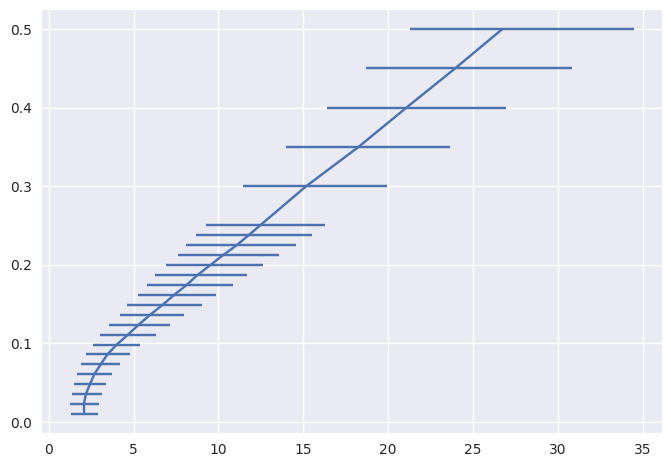

In [37]:
min = []
max = []

for data in alldata:
    mean = np.mean(data[~np.isnan(data)])
    min.append(mean - np.percentile(data[~np.isnan(data)],10))
    max.append(np.percentile(data[~np.isnan(data)],90) - mean)
    
plt.errorbar(means,signals,None,np.array([min,max]))

array([0.72645483, 0.72969984, 0.74905879, ..., 3.95553502,
       4.00187253, 4.0638882 ], shape=(264,))

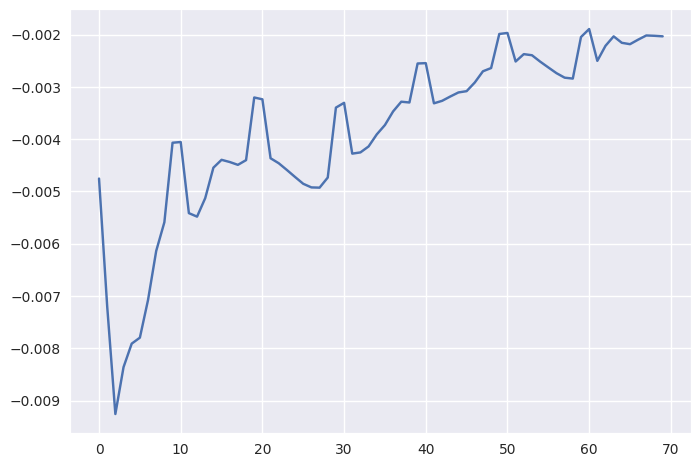

In [15]:
list = np.array(alldata[0])
list = list[~np.isnan(list)]
mean = np.mean(list)
sorted = np.sort(list)
stdlist =[]
for i in np.linspace(0,sorted.__len__()//2-1,70):
    stdlist.append(np.std(sorted[int(i):]))

plt.plot(np.gradient(stdlist))
# plt.plot(stdlist)
sorted
# plt.hist(sorted,50)

In [ ]:
import pickle

# with open(filepath+'130epRevisedCoordinateGen.pkl'.format(1.2),'wb') as f:
#     pickle.dump(alldata,f)


(array([  1.,   0.,   0.,   3.,   1.,   0.,   0.,   0.,   2.,
          3.,   3.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   4.,  14.,  19.,  31.,  32.,  35.,
         38.,  48.,  37.,  39.,  40.,  44.,  44.,  34.,  43.,
         49.,  43.,  56.,  72.,  72.,  72.,  94., 123.,  99.,
         97.,  74.,  84.,  72.,  64.,  61.,  56.,  67.,  36.,
         39.,  41.,  48.,  41.,  40.,  45.,  53.,  71.,  68.,
         59.,  55.,  80.,  57.,  52.,  45.,  42.,  47.,  37.,
         47.,  34.,  30.,  26.,  16.,   7.,   5.,   4.,   1.]),
 array([ 3.49512023,  3.77663434,  4.05814845,  4.33966256,
         4.62117667,  4.90269079,  5.1842049 ,  5.46571901,
         5.74723312,  6.02874723,  6.31026135,  6.59177546,
         6.87328957,  7.15480368,  7.43631779,  7.71783191,
         7.99934602,  8.28086013,  8.56237424,  8.84388835,
         9.12540247,  9.40691658,  9.68843069,  9.9699448 ,
        10.2514589

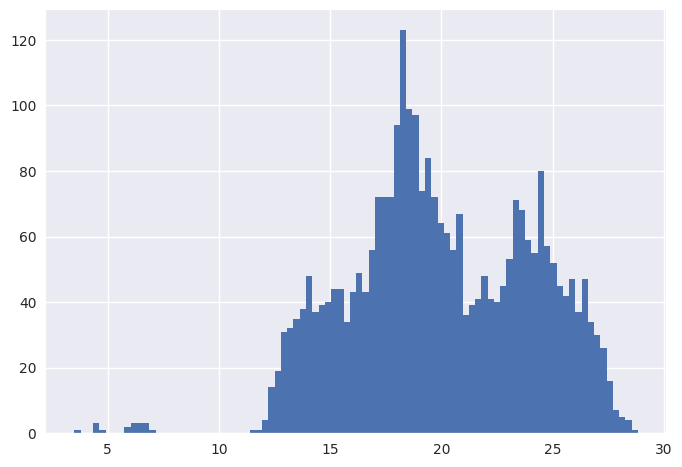

In [36]:
plt.hist(alldata[2],90)
# alldata[0]
# alldata


In [9]:
df = 2
dt= 2
arr = np.arange(100).reshape((10,10))
print(arr)
x=np.size(arr,0)
y=np.size(arr,1)
sum = arr.reshape(x//dt,dt,y//df,df).transpose(0,2,1,3).reshape(-1,df*dt).sum(axis=1)
shape = np.reshape(sum,(x//dt,y//df))
np.repeat(np.repeat(shape,df,axis=0),dt,axis=1)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


array([[ 22,  22,  30,  30,  38,  38,  46,  46,  54,  54],
       [ 22,  22,  30,  30,  38,  38,  46,  46,  54,  54],
       [102, 102, 110, 110, 118, 118, 126, 126, 134, 134],
       [102, 102, 110, 110, 118, 118, 126, 126, 134, 134],
       [182, 182, 190, 190, 198, 198, 206, 206, 214, 214],
       [182, 182, 190, 190, 198, 198, 206, 206, 214, 214],
       [262, 262, 270, 270, 278, 278, 286, 286, 294, 294],
       [262, 262, 270, 270, 278, 278, 286, 286, 294, 294],
       [342, 342, 350, 350, 358, 358, 366, 366, 374, 374],
       [342, 342, 350, 350, 358, 358, 366, 366, 374, 374]])

In [10]:
matrix = np.arange(16).reshape(4,4)
dx = 2
dy =2

m, n = matrix.shape

# Ensure the dimensions are divisible by dy and dx
if m % dy != 0 or n % dx != 0:
    raise ValueError("Matrix dimensions must be divisible by tile dimensions.")

# Reshape into blocks and sum
reshaped = matrix.reshape(m // dy, dy, n // dx, dx)
summed = reshaped.sum(axis=(1, 3)) 
stretched = np.kron(summed, np.ones((dy, dx))).astype(int)
stretched


array([[10, 10, 18, 18],
       [10, 10, 18, 18],
       [42, 42, 50, 50],
       [42, 42, 50, 50]])

In [31]:
m_list = mlists[0]

print(mlists[0])

# np.ravel(m_list)
plt.hist(np.sqrt(np.sum(np.square(np.vstack(m_list)),axis=1)),50)

# np.sum(np.array(m_list)**2,axis=1)


# plt.hist(np.hstack(ms)/.1,50)

[array([[ 0.28219451, -0.35932724,  0.03324919]]), array([[-0.2009796 ,  0.36920292, -0.0741775 ],
       [ 0.3602152 , -0.13590298,  0.35218462],
       [ 0.14437061,  0.05759843, -0.32015017]]), array([[ 0.36707924, -0.08314506,  0.27903832],
       [-0.27933146,  0.30042071,  0.31466339],
       [ 0.19723278,  0.24010684, -0.19774814],
       [-0.0663495 ,  0.40701919, -0.25590169]]), array([[-0.01463691,  0.24897509,  0.08573438]]), array([[ 0.10253812,  0.23807197,  0.08157126],
       [-0.01189323,  0.24392818,  0.18801642]]), array([[ 0.00706267, -0.02439219,  0.29609928]]), array([[0.20946207, 0.0628928 , 0.02998096]]), array([[ 0.17442104, -0.02103458, -0.46764278]]), array([[-0.14153283,  0.37516346, -0.13995468],
       [-0.21360749,  0.25282651,  0.28282564]]), array([[-0.19138494,  0.34753535, -0.03802278],
       [ 0.25639659,  0.08552603, -0.01135802],
       [-0.21633213,  0.33055189, -0.11220773]]), array([], dtype=float64), array([[ 0.26973935,  0.26603243, -0.0637037

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 10 has size 0

In [38]:
x=np.linspace(0,19, 20)
y=np.linspace(0,9,10)
xarr, yarr = np.meshgrid(x,y)
np.vstack([xarr.ravel(), yarr.ravel()]).reshape(20,20)

array([[ 0.,  1.,  2., ..., 17., 18., 19.],
       [ 0.,  1.,  2., ..., 17., 18., 19.],
       [ 0.,  1.,  2., ..., 17., 18., 19.],
       ...,
       [ 7.,  7.,  7., ...,  7.,  7.,  7.],
       [ 8.,  8.,  8., ...,  8.,  8.,  8.],
       [ 9.,  9.,  9., ...,  9.,  9.,  9.]], shape=(20, 20))

In [13]:
xlen = 5
ylen = 5
y,x=np.meshgrid(np.arange(ylen),np.arange(xlen), indexing='ij')
# arr = np.stack((y,x),axis=-1)
x
# arr[3,4]
ma.array(y,mask=x)

masked_array(
  data=[[0, --, --, --, --],
        [1, --, --, --, --],
        [2, --, --, --, --],
        [3, --, --, --, --],
        [4, --, --, --, --]],
  mask=[[False,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False,  True,  True,  True,  True]],
  fill_value=999999)

In [14]:
(x.all(1).__invert__()*x.T).T.std(1)

array([1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356])

In [12]:
np.sqrt(np.sum(np.arange(21).reshape(7,3)**2,axis=1))

array([ 2.23606798,  7.07106781, 12.20655562, 17.3781472 ,
       22.56102835, 27.74887385, 32.93933818])

In [16]:
mask1 = ma.array(np.arange(5),mask=[1,1,1,0,0])
mask2 = ma.array(np.arange(5),mask=[0,0,1,1,1])

mask1.__setmask__(mask1.mask & mask2.mask)
mask1.mask

array([False, False,  True, False, False])